# Sanity Checker 3

#### utilizes the classes found in `PatchAnalyzer/utils/ephys_analyzer.py` and `PatchAnalyzer/model/data_loader.py` to calculate the following parameters:
* 1️⃣ Passive properties from VC (optional) & CC sweeps  
* 2️⃣ Spike detection → F–I curve & per-spike metrics  
* 3️⃣ One-click plot toggles for debugging  
* Copy-paste-ready cells; all user inputs live in the next “Config” cell


In [ ]:
# ---------------------------------------------------------------------
# 🛠️  USER CONFIG  – fill / tweak these and rerun the rest of the nb
# ---------------------------------------------------------------------


# 0. IMPORT NECCESSARY LIBRARYS ------------------------------------------------
from pathlib import Path
import sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 1. SET PATH FOR EXPERIMENT FOLDER -------------------------------------------
# EXP_DIR = Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_07_02-13_09")
EXP_DIR = Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Levi_control_cultured_exp\Cohort_2\2025_09_24-17_04")

# 2. SELECT A SET OF PROTOCOLS USING CELL_ID -----------------------------------
CELL_ID = 3          # int

# 3. FLAGS TO DETERMINE VISUALIZATION AND VERBOSE RESULTS ----------------------
VERBOSE             = True   # tables & plots
NORMALIZE_BY_CM     = True   # add pA / pF columns / axes
SHOW_RAW_PLOTS      = True
SHOW_PASSIVE_PLOTS  = True
SHOW_FI_PLOTS       = True
SHOW_SPIKE_PLOTS    = True

# --- repo on sys.path + misc --------------------------------------------------
if not EXP_DIR.exists():
    raise RuntimeError(f"EXP_DIR does not exist: {EXP_DIR}")
repo_root = EXP_DIR.parents[3]
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

plt.rcParams["figure.dpi"] = 110
warnings.filterwarnings("ignore", category=RuntimeWarning)





2025-10-08 21:18:00,219 [INFO] Loaded 6 rows from C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Rowan_GFP_TAU_exp\2025_06_29-15_14\CellMetadata\cell_metadata.csv


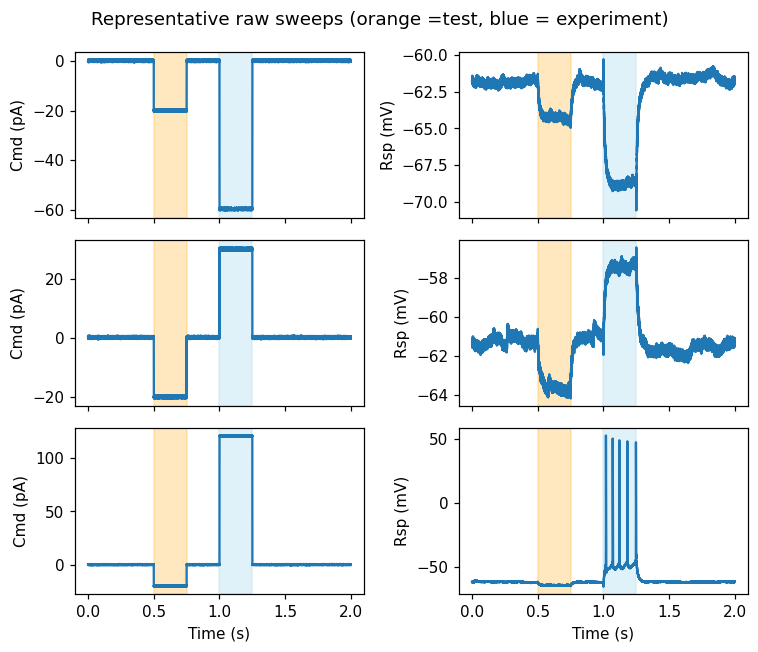

In [31]:
# ---------------------------------------------------------------------
# 🔄  LOAD METADATA + ALL TRACES for the chosen experiment
# ---------------------------------------------------------------------
from PatchAnalyzer.models.data_loader import (
    load_metadata,
    load_voltage_traces_for_indices,
    load_current_sweeps,
)
from PatchAnalyzer.utils.ephys_analyzer import VprotAnalyzer, CprotAnalyzer
import warnings, matplotlib.pyplot as plt

# 0. LOAD VOLTAGE DATA FOR GIVEN CELL_ID ---------------------------------------
meta_df  = load_metadata([EXP_DIR])
idx_col  = "indices" if "indices" in meta_df.columns else "index"
vp_idxs  = meta_df[idx_col].tolist()
vc_traces = load_voltage_traces_for_indices(EXP_DIR, vp_idxs)

# 1. LOAD CURRENT DATA FOR GIVEN CELL_ID ---------------------------------------
cc_dict  = load_current_sweeps(EXP_DIR, [CELL_ID])
if CELL_ID not in cc_dict:
    raise RuntimeError(f"CELL_ID {CELL_ID} not found in {EXP_DIR}")
cc_sweeps = cc_dict[CELL_ID]

# 2. BUILD ANALYZER OBJECTS ----------------------------------------------------
v_an = VprotAnalyzer(debug=False)
c_an = CprotAnalyzer(debug=False)

# ---- diagnostic raw-trace plot ----------------------------------------------
if VERBOSE and SHOW_RAW_PLOTS and cc_sweeps:
    sel = [0, len(cc_sweeps)//2, len(cc_sweeps)-1] if len(cc_sweeps) > 2 else range(len(cc_sweeps))
    fig, axs = plt.subplots(len(sel), 2, figsize=(7, 2*len(sel)), sharex='col')
    if len(sel) == 1:
        axs = [axs]                   # always iterable
    for ax_pair, idx in zip(axs, sel):
        sw  = cc_sweeps[idx]
        t   = sw.time
        cmd = sw.command_pA
        rsp = sw.response_mV
        ts, te = c_an._find_test_pulse(cmd)
        es, ee = c_an._find_experimental_pulse(cmd, te)
        ax_pair[0].plot(t, cmd); ax_pair[0].set_ylabel("Cmd (pA)")
        ax_pair[1].plot(t, rsp); ax_pair[1].set_ylabel("Rsp (mV)")
        if ts is not None:
            for a in ax_pair: a.axvspan(t[ts], t[te], color='orange', alpha=.25)
        if es is not None:
            for a in ax_pair: a.axvspan(t[es], t[ee], color='skyblue', alpha=.25)
    axs[-1][0].set_xlabel("Time (s)")
    axs[-1][1].set_xlabel("Time (s)")
    plt.suptitle("Representative raw sweeps (orange =test, blue = experiment)")
    plt.tight_layout(); plt.show()


Voltage-Clamp passive (mean):  Ra=29.9 MΩ   Rm=87.5 MΩ   Cm=55.3 pF  Tau=1.2 ms


,membrane_tau_ms,input_resistance_MOhm,membrane_capacitance_pF,resting_potential_mV,holding_current_pA
sweep,,,,,
1,16.664929,130.279327,127.916914,-61.855553,0.107826
2,15.480589,129.986436,119.093882,-61.483945,0.124453
3,12.258076,121.374541,100.993797,-61.416621,0.139610
4,25.527679,156.329744,163.293806,-60.911834,0.142296
5,11.046393,119.616848,92.348136,-61.392592,0.129825
6,14.643709,134.512364,108.865152,-61.186658,0.145813
7,11.383619,131.761952,86.395340,-61.088771,0.190387
8,6.504324,104.040903,62.516993,-61.315922,0.181625
9,15.230712,125.967473,120.909882,-61.191930,0.189171


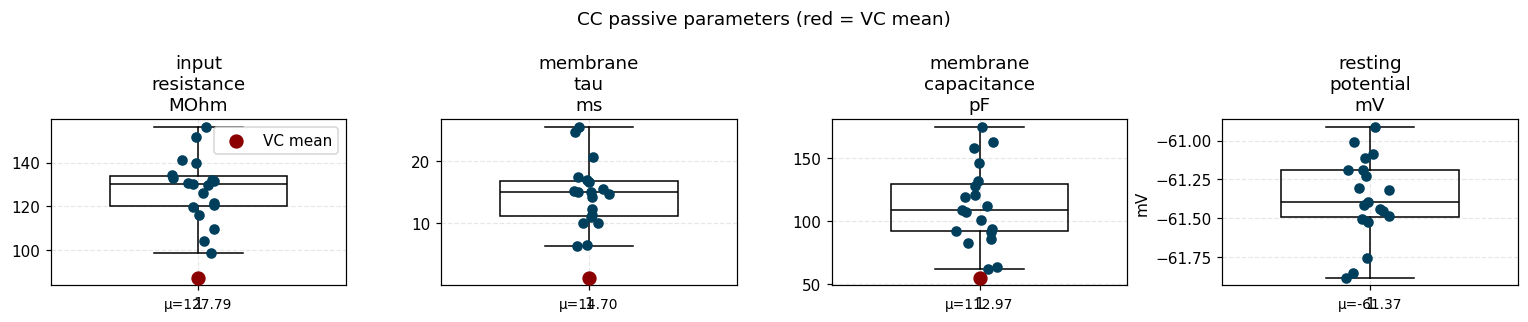

In [32]:
# -----------------------------------------------------------------------------------------
# 🔍  CURRENT-CLAMP and VOLTAGE-CLAMP passive parameters – per sweep
# -----------------------------------------------------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1.A  VOLTAGE-CLAMP passives ---------------------------------------------------
Ra_MΩ, Rm_MΩ, Cm_pF = v_an.fit_cell(vc_traces, aggregate="mean")
Ra_Ω = float(Ra_MΩ)*1e6
Rm_Ω = float(Rm_MΩ)*1e6
R_para = 1 / (1 /Ra_Ω + 1 / Rm_Ω)
Cm_F = float(Cm_pF)*1e-12
tau_s = Cm_F*R_para
tau_ms = tau_s*1e3
if VERBOSE:
    print(f"Voltage-Clamp passive (mean):  Ra={Ra_MΩ:.1f} MΩ   Rm={Rm_MΩ:.1f} MΩ   Cm={Cm_pF:.1f} pF  Tau={tau_ms:.1f} ms")

# 2.A/B  CURRENT-CLAMP per-sweep passives --------------------------------------
passive_rows = []
for s_idx, sw in enumerate(cc_sweeps, 1):
    try:
        res = c_an.passive_params(
            sw.time,
            sw.command_pA / c_an.cclamp_gain,   # pA → V
            sw.response_mV / c_an.vclamp_gain, # mV → V
            return_intermediates=False,
        )
        res["sweep"] = s_idx
        passive_rows.append(res)
    except RuntimeError as exc:
        warnings.warn(f"Sweep {s_idx}: {exc}")

cc_passive_df = pd.DataFrame(passive_rows).set_index("sweep")
if VERBOSE:
    display(cc_passive_df)

# ---- box-and-whisker with VC overlay & robust outlier handling ----------
props = ["input_resistance_MOhm",
         "membrane_tau_ms",
         "membrane_capacitance_pF",
         "resting_potential_mV"]

clean_vals, outliers = {}, {}
for p in props:
    vals = cc_passive_df[p].dropna()

    # ------- robust filter: Median ± 3 × MAD -----------------------------
    med = np.median(vals)
    mad = np.median(np.abs(vals - med)) or 1e-12      # avoid zero-mad
    thresh = 5 * 1.4826 * mad                         # MAD → SD-like
    keep = vals[np.abs(vals - med) <= thresh]
    out  = vals[np.abs(vals - med) >  thresh]

    clean_vals[p], outliers[p] = keep, out

if VERBOSE and SHOW_PASSIVE_PLOTS:
    fig, axs = plt.subplots(1, len(props), figsize=(3.5*len(props), 3))
    for ax, p in zip(axs, props):
        ax.boxplot(
            clean_vals[p],
            widths=.6,
            whis=[0, 100],              # whiskers span full range
            showfliers=False,           # no Matplotlib “fliers”
            patch_artist=True,
            boxprops   =dict(facecolor='none', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops   =dict(color='black'),
        )
        ax.scatter(np.random.normal(1, 0.04, len(clean_vals[p])),
                   clean_vals[p], s=35, color='#003f5c', zorder=3)

        # VC overlay (red circle) ---------------------------------------
        overlay = {"input_resistance_MOhm": Rm_MΩ,
                "membrane_tau_ms":       tau_ms,   # ← NEW
                "membrane_capacitance_pF": Cm_pF}.get(p, np.nan)
        if not np.isnan(overlay):
            ax.scatter([1], [overlay], c='#8b0000', marker='o',
                       s=70, zorder=4, label='VC mean')

        ax.set_title(p.replace("_", "\n"))
        ax.grid(True, linestyle='--', alpha=.3)
        if p == "resting_potential_mV":
            ax.set_ylabel("mV")
        else:
            ax.ticklabel_format(axis='y', style='plain')

        # mean value written underneath axis ----------------------------
        mu = clean_vals[p].mean()
        ax.text(1, ax.get_ylim()[0] - 0.07*np.ptp(ax.get_ylim()),
                f"μ={mu:.2f}", ha='center', va='top', fontsize=9)

    axs[0].legend(loc="best")
    plt.suptitle("CC passive parameters (red = VC mean)")
    plt.tight_layout(); plt.show()

# ---- recompute mean Cm (from cleaned values) ----------------------------
Cm_mean_pF = clean_vals["membrane_capacitance_pF"].mean()


C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\PatchAnalyzer\utils\ephys_analyzer.py:514: UserWarning: Sweep 7: no experimental pulse detected
  warnings.warn("; ".join(skips))


,sweep,current_inj_pA,mean_firing_frequency_Hz,current_inj_pApF
0,1,-59.880051,0.00000,-0.530069
1,2,-49.855741,0.00000,-0.441332
2,3,-39.993392,0.00000,-0.354028
3,4,-29.948351,0.00000,-0.265108
4,5,-20.004264,0.00000,-0.177081
5,6,-9.892167,0.00000,-0.087567
6,8,10.108170,0.00000,0.089479
7,9,20.055370,0.00000,0.177534
8,10,29.853706,0.00000,0.264270
9,11,39.899699,0.00000,0.353199


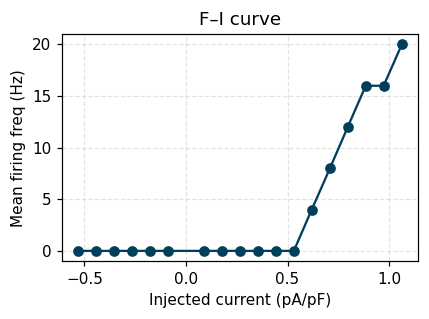

In [33]:
# ---------------------------------------------------------------------
# ⚡  SPIKE DETECTION  &  F–I CURVE
# ---------------------------------------------------------------------
sweep_tuples = [
    (sw.time,
     sw.command_pA / c_an.cclamp_gain,    # back-convert to Volts
     sw.response_mV / c_an.vclamp_gain)   # back-convert to Volts
    for sw in cc_sweeps
]

fi_df = c_an.firing_curve(
    sweep_tuples,
    normalize_by_Cm=NORMALIZE_BY_CM,
    Cm_pF=Cm_mean_pF if NORMALIZE_BY_CM else None,
)
# --- auto-fix if values ended up in A/pF (≤1e-6) -----------------------
if NORMALIZE_BY_CM and fi_df["current_inj_pApF"].abs().max() < 1e-6:
    fi_df["current_inj_pApF"] *= 1e12   # A➜pA

if VERBOSE: display(fi_df)

if VERBOSE and SHOW_FI_PLOTS and not fi_df.empty:
    x = "current_inj_pApF" if NORMALIZE_BY_CM else "current_inj_pA"
    plt.figure(figsize=(4,3))
    plt.plot(fi_df[x], fi_df["mean_firing_frequency_Hz"], 'o-',
             color='#003f5c', markerfacecolor='#003f5c')
    plt.xlabel("Injected current (pA/pF)" if NORMALIZE_BY_CM else "Injected current (pA)")
    plt.ylabel("Mean firing freq (Hz)")
    plt.title("F–I curve")
    plt.grid(True, linestyle='--', alpha=.35)
    plt.tight_layout(); plt.show()



C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\PatchAnalyzer\utils\ephys_analyzer.py:595: UserWarning: Sweep 7: no experimental pulse detected
  warnings.warn("; ".join(skips))


,sweep,spike_number,current_inj_pA,peak_mV,half_width_ms,AHP_mV,threshold_mV,dvdt_max_mV_per_ms,current_inj_pApF
0,14,0,69.940694,54.702812,0.130001,106.316941,54.798622,421.561012,0.619127
1,15,0,80.041597,54.096017,0.120001,106.732117,54.191826,418.367368,0.708542
2,15,1,80.041597,52.914362,0.130001,104.368809,53.105982,402.399148,0.708542
3,16,0,89.934403,53.201792,0.140001,105.933702,53.329538,432.738766,0.796115
4,16,1,89.934403,52.371440,0.130001,103.506521,52.435313,394.415038,0.796115


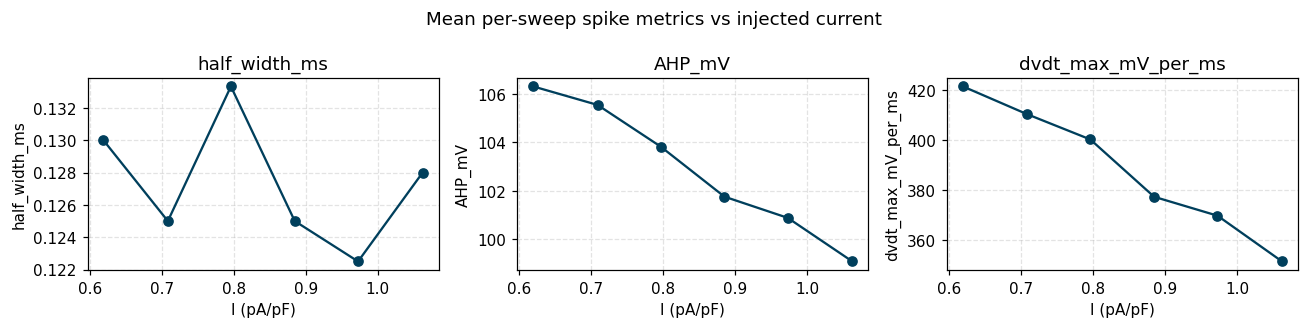

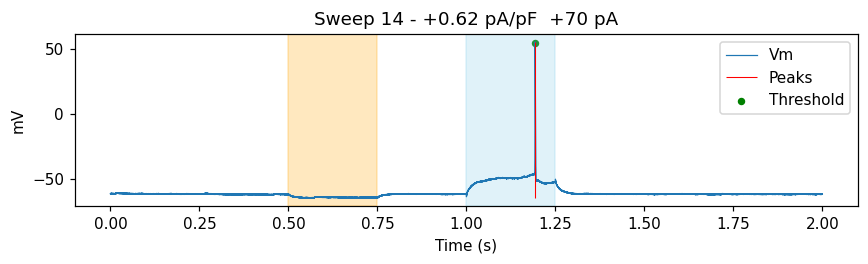

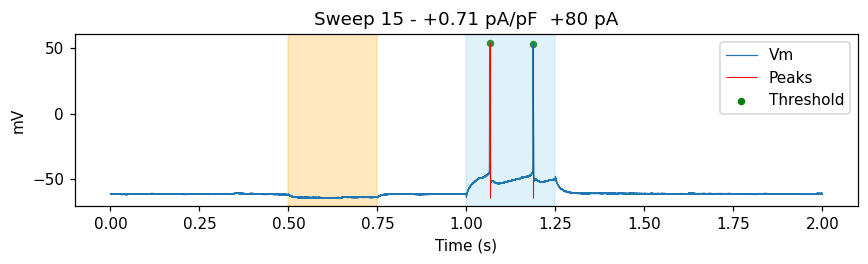

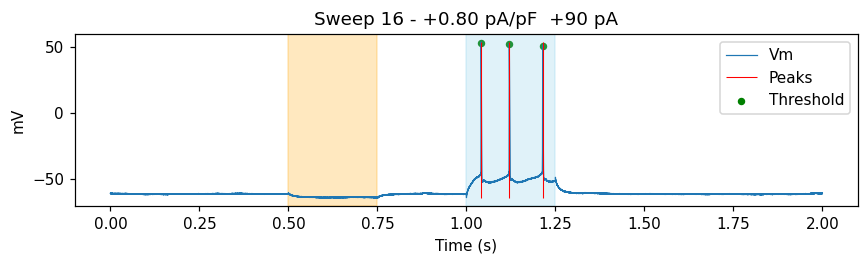

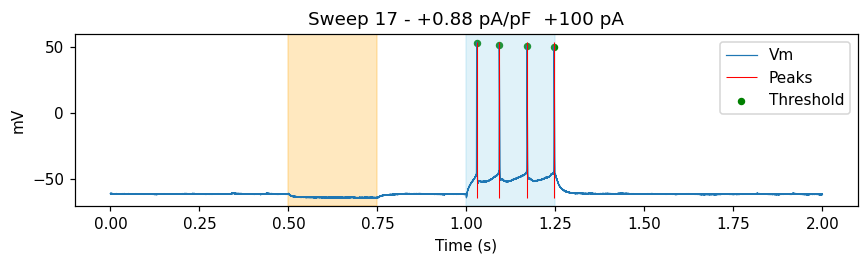

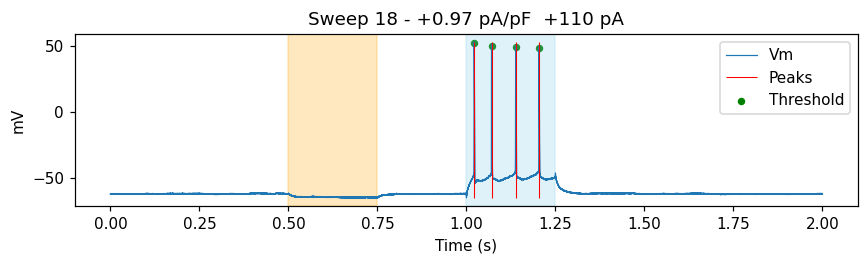

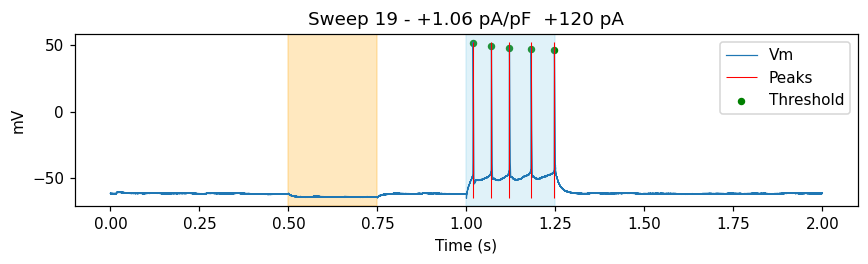

In [34]:
# ---------------------------------------------------------------------
# 🔬  PER-SPIKE METRICS  (half-width, AHP, threshold, dV/dt-max)
# ---------------------------------------------------------------------
spk_df = c_an.spike_metrics(
    sweep_tuples,
    normalize_by_Cm=NORMALIZE_BY_CM,
    Cm_pF=Cm_mean_pF if NORMALIZE_BY_CM else None,
)
# --- auto-fix unit if needed ------------------------------------------
if NORMALIZE_BY_CM and "current_inj_pApF" in spk_df.columns:
    if spk_df["current_inj_pApF"].abs().max() < 1e-6:
        spk_df["current_inj_pApF"] *= 1e12

if VERBOSE: display(spk_df.head())

if VERBOSE and SHOW_SPIKE_PLOTS and not spk_df.empty:
    metrics = ["half_width_ms", "AHP_mV", "dvdt_max_mV_per_ms"]
    xkey = "current_inj_pApF" if NORMALIZE_BY_CM else "current_inj_pA"

    grp = spk_df.groupby(xkey)               # aggregate by injected current
    fig, axs = plt.subplots(1, len(metrics), figsize=(4*len(metrics), 3))

    for ax, m in zip(axs, metrics):
        means = grp[m].mean()
        ax.plot(means.index, means.values, 'o-', color='#003f5c')
        ax.set_xlabel("I (pA/pF)" if NORMALIZE_BY_CM else "I (pA)")
        ax.set_ylabel(m)
        ax.set_title(m)
        ax.grid(True, linestyle='--', alpha=.35)

    plt.suptitle("Mean per-sweep spike metrics vs injected current")
    plt.tight_layout(); plt.show()

    # --- diagnostic plots (every sweep with spikes) ---------------
    for sw_idx, sw in enumerate(cc_sweeps, start=1):
        ts, te = c_an._find_test_pulse(sw.command_pA)
        es, ee = c_an._find_experimental_pulse(sw.command_pA, te)
        if es is None or ee is None:
            continue
        sr_Hz = 1.0 / (sw.time[1] - sw.time[0])
        peaks = c_an._detect_spikes(sw.response_mV[es:ee], sr_Hz) + es
        if not len(peaks):
            continue
        sweep_rows = spk_df.loc[spk_df["sweep"] == sw_idx].sort_values("spike_number")
        thresh_vals = sweep_rows["threshold_mV"].to_numpy()
        if thresh_vals.size and thresh_vals.size != len(peaks):
            n = min(len(peaks), thresh_vals.size)
            peaks = peaks[:n]
            thresh_vals = thresh_vals[:n]
        label_bits = []
        if "current_inj_pApF" in sweep_rows.columns and not sweep_rows.empty:
            label_bits.append(f'{sweep_rows["current_inj_pApF"].iloc[0]:+.2f} pA/pF')
        if "current_inj_pA" in sweep_rows.columns and not sweep_rows.empty:
            label_bits.append(f'{sweep_rows["current_inj_pA"].iloc[0]:+.0f} pA')
        title_suffix = "  ".join(label_bits)
        plt.figure(figsize=(8, 2.5))
        plt.plot(sw.time, sw.response_mV, lw=.8, label="Vm")
        plt.vlines(sw.time[peaks], sw.response_mV.min(), sw.response_mV.max(), color='red', lw=.7, label="Peaks")
        if thresh_vals.size:
            plt.scatter(sw.time[peaks], thresh_vals, c='green', s=15, label="Threshold")
        if ts is not None and te is not None:
            plt.axvspan(sw.time[ts], sw.time[te], color='orange', alpha=.25)
        plt.axvspan(sw.time[es], sw.time[ee], color='skyblue', alpha=.25)
        plt.ylabel("mV"); plt.xlabel("Time (s)")
        title = f"Sweep {sw_idx}" + (f" - {title_suffix}" if title_suffix else "")
        plt.title(title)
        plt.legend(loc="upper right")
        plt.tight_layout(); plt.show()




